In [281]:
#подключение необходимых библиотек и модулей
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.preprocessing import MinMaxScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

# Домашнее задание №5

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Решение

**0. Загрузка датасета и подготовка признаков**

Загрузка датасета

In [282]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [283]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

Преобразуем признаки:
- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные признаки нормируем

In [284]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [285]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [286]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('normalize', MinMaxScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Pipline, который готовит признаки для моделирования

In [287]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

**1. Построение моделей классификации**

Построим две модели: 1 -- бустинг, 2 -- логистическая регрессия

In [288]:
models = ['CatBoostClassifier', 'LogisticRegression']
metrics = ['f-score', 'precision', 'recall']

Создадим модель №1 (бустинг)

In [289]:
pipeline_1 = Pipeline([
    ('features',feats),
    ('boosting', CatBoostClassifier(iterations=20, 
                                    thread_count=2, 
                                    random_state=42, 
                                    silent=True,
                                    eval_metric='F1',
                                    early_stopping_rounds=20)
                                     ),
])

#обучим пайплайн_1
pipeline_1.fit(X_train, y_train)

#делаем прогнозы для тестовой выборки
preds_1 = pipeline_1.predict_proba(X_test)[:, 1]
preds_1[:10]

array([0.17868716, 0.25274061, 0.10568407, 0.01625305, 0.03953028,
       0.78672713, 0.02726497, 0.06452932, 0.13468734, 0.8897924 ])

Получим значения метрик для модели

In [290]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_1)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
boost_metrics = [fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.415090, F-Score=0.643, Precision=0.669, Recall=0.619


Просмотр матрицы ошибок<a class="anchor" id="matrix"></a><center>

Confusion matrix, without normalization
[[1835  156]
 [ 195  314]]


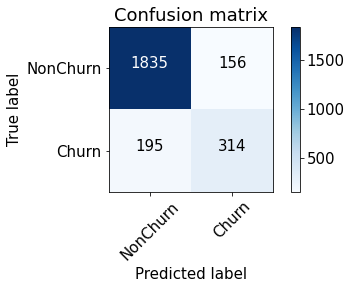

In [291]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_1>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Создадим модель №2 (Логистическа регрессия)

In [292]:
pipeline_2 = Pipeline([
    ('features',feats),
    ('lr', LogisticRegression(random_state = 42))])

#обучим пайплайн_2
pipeline_2.fit(X_train, y_train)

#делаем прогнозы для тестовой выборки
preds_2 = pipeline_2.predict_proba(X_test)[:, 1]
preds_2[:10]

array([0.23147871, 0.33342815, 0.15457985, 0.12706248, 0.15737546,
       0.63172834, 0.06396248, 0.08071225, 0.35749076, 0.75533412])

Получим значения метрик для модели

In [293]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_2)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

lr_metrics = [fscore[ix], precision[ix], recall[ix]]

Best Threshold=0.286079, F-Score=0.509, Precision=0.460, Recall=0.570


Просмотр матрицы ошибок

Confusion matrix, without normalization
[[1650  341]
 [ 220  289]]


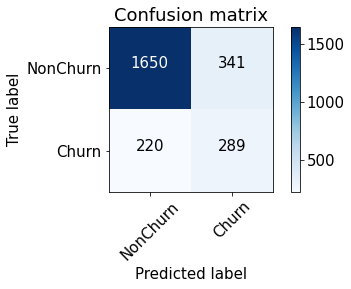

In [294]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_2>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

**2. Отбор лучшей модели по метрикам**

Сводная таблица результатов моделей

In [295]:
metrics_data = pd.DataFrame([[models[0]] + boost_metrics,[models[1]] + lr_metrics], columns = ['model'] + metrics)
metrics_data

,model,f-score,precision,recall
0,CatBoostClassifier,0.642857,0.668790,0.618861
1,LogisticRegression,0.508772,0.459588,0.569745


Наиболее подходящая DS-метрика, скорее всего, f-score.

**Вывод:** модель CatBoostClassifier имеет лучшие показатели метрик.

**3. Оценка экономической эффективности модели CatBoostClassifier**

Сделаем оценку экономической эффективности модели CatBoostClassifier. \
Пусть на удержание одного пользователя уходит 1 доллар, \
средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. 
(подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

0) Рассчет бизнес-метрик по матрице ошибок

FP -- убыток компании = траты на удержание клиентов, \
TP -- возможная прибыль компании = пожизненная ценность клиентов - траты на их удержание, \
FN -- убыток компании = пожизненная ценность клиентов, \
TN -- убыток компании = прибыль компании = 0 от машинного обучения.

1) Исходя из [матрицы ошибок CatBoostClassifier](#matrix), имеем:

FP = 156, TP = 314, FN = 195, TN = 1835.

2) Посчитаем траты на рекламную кампанию по удержанию клиентов (всех, кто собирается в отток по прогнозу): 

1 * (FP + TP) = 1 * (156 + 314) = 470 ($)

3) Возможная прибыль компании (в случае удержания всех TP):

2 * TP - 1 * TP = TP = 314 ($)

4) Рассчитаем выручку от оставшихся клиентов:

2 * FP = 2 * 156 = 312 ($)

Итого:\
траты компании: 470 долларов\
средняя ожидаемая прибыль: 314 долларов,\
выручка: 312 долларов.

Так как траты компании > средней ожидаемой прибыли, то применение кампании по удержанию клиентов экономически не выгодно.

Так как траты компании > выручки, то применение модели ML экономически не целесообразно.

**Вывод:** модель экономически не целесообразна.

**4*. Подбор гиперпараметров лучшей модели**

In [296]:
#сетка с параметрами
params = {'boosting__iterations':[20, 40, 50, 100, 200, 500, 700, 1000],
          'boosting__max_depth':[2, 3, 4, 5, 7,10]}

In [297]:
#перебор
grid = GridSearchCV(pipeline_1,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'boosting__iterations': 500, 'boosting__max_depth': 4}

Обучение модели с новыми параметрами

In [298]:
pipeline_1_gs = Pipeline([
    ('features',feats),
    ('boosting', CatBoostClassifier(thread_count=2, 
                                    random_state=42, 
                                    silent=True,
                                    eval_metric='F1',
                                    early_stopping_rounds=20,
                                    iterations=500,
                                    max_depth=4)
                                     ),
])

#обучим пайплайн_1_gs
pipeline_1_gs.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Предсказания и метрики модели с новыми параметрами<a class="anchor" id="matrix_2"></a><center>

Best Threshold=0.387423, F-Score=0.650, Precision=0.672, Recall=0.629
Confusion matrix, without normalization
[[1835  156]
 [ 190  319]]


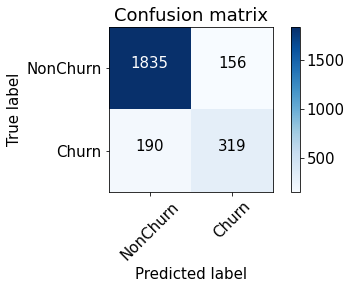

In [299]:
preds_gs = pipeline_1_gs.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds_gs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

model_gs_metrics = [fscore[ix], precision[ix], recall[ix]]
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gs>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Сводная таблица результатов моделей

In [300]:
metrics_data = pd.DataFrame([[models[0]] + boost_metrics,['CatBoostClassifier_best_params'] + model_gs_metrics], columns = ['model'] + metrics)
metrics_data

,model,f-score,precision,recall
0,CatBoostClassifier,0.642857,0.668790,0.618861
1,CatBoostClassifier_best_params,0.649746,0.672269,0.628684


**Вывод:** значения метрик у модели с лучшими параметрами немного выше, чем у базовой.

**5*. Оценка экономической эффективности для улучшенной модели**

1) Исходя из [матрицы ошибок CatBoostClassifier_best_params](#matrix_2), имеем:

FP = 156, TP = 319, FN = 190, TN = 1835.

2) Посчитаем траты на рекламную кампанию по удержанию клиентов (всех, кто собирается в отток по прогнозу): 

1 * (FP + TP) = 1 * (156 + 319) = 475 ($)

3) Возможная прибыль компании (в случае удержания всех TP):

2 * TP - 1 * TP = TP = 319 ($)

4) Рассчитаем выручку от оставшихся клиентов:

2 * FP = 2 * 156 = 312 ($)

Итого:\
траты компании: 475 долларов,\
средняя ожидаемая прибыль: 319 долларов,\
выручка: 312 долларов.

Так как траты компании > средней ожидаемой прибыли, то применение кампании по удержанию клиентов экономически не выгодно.

Так как траты компании > выручки, то применение модели ML экономически не целесообразно.

**Вывод:** модель экономически не целесообразна